**Xem thông tin GPU trên Google Colab**

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7d50e927-6fa7-849d-6da8-45f0821019f1)


**Import các thư viện cần thiết**

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**Tiến hành xây dựng mô hình RankNet ở dạng kiến trúc một mạng nơ-ron với 2 tầng ẩn (hidden layers) - 1 tầng đầu ra (output layer)**

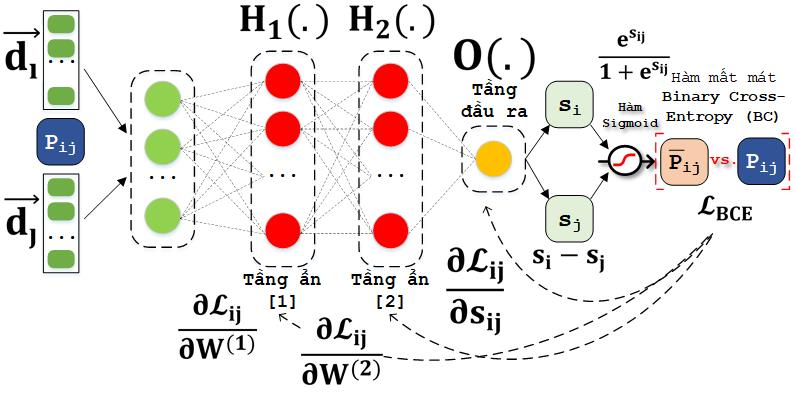

In [3]:
# Định nghĩa mô hình RankNet - kế thừa từ một Tensorflow Model
class RankNet(Model):
    def __init__(self):
        super().__init__()
        # Định nghĩa hai tầng ẩn (hidden layers) - là tầng kết nối toàn diện (dense), lần lượt:
        # Tầng ẩn H1(.) -> có số lượng neuron là [32] - hàm kích hoạt là hàm LeakyRELU
        # Tầng ẩn H2(.) -> có số lượng neuron là [32] - hàm kích hoạt là hàm LeakyRELU
        self.hidden_layers = [layers.Dense(32, activation=leaky_relu, name="Tang_An_1"), 
                              layers.Dense(32, activation=leaky_relu, name="Tang_An_2")]
        # Định nghĩa tầng đầu ra (output layer) - là tầng kết nối toàn diện (dense) - có số lượng neuron là [1]
        # Tầng đầu ra có hàm kích hoạt là một hàm tuyến tính.
        self.output_layer = layers.Dense(1, activation='linear', name="Tang_Dau_Ra")
        # Ngoài ra chúng ta định nghĩa một tầng phụ dùng để thực hiện phép trừ (si - sj)
        self.si_minus_sj_layer = layers.Subtract(name="Phep_Tru_sij")

        self.sigmoid_layer = layers.Activation('sigmoid', name="Ham_Sigmoid")
    
    # Khai báo các thủ tục của quá trình suy diễn tiến (feed-forward)
    def call(self, inputs):
        # Đầu vào của mô hình sẽ nhận hai vectors đại diện cho tài liệu (di) và (dj)
        di, dj = inputs

        # Truyền (di) và (dj) và từng tầng ẩn: tầng ẩn [1] và [2]
        # Ở mỗi tầng ẩn - sau khi vectors (di) và (dj) truyền qua
        # Chúng ta sẽ thu được trạng thái ẩn (hidden states, ký hiệu: h) của (di) và (dj)
        hi = self.hidden_layers[0](di)
        hj = self.hidden_layers[0](dj)
        for hidden_layer in self.hidden_layers[1:]:
            hi = hidden_layer(hi)
            hj = hidden_layer(hj)

        # Và cuối cùng là truyền vào tầng đầu ra output để thu (si) và (sj)
        si = self.output_layer(hi)
        sj= self.output_layer(hj)

        # Tiếp theo đó ta sẽ thực phép trừ si - sj để thu được (sij)
        sij = self.si_minus_sj_layer([si, sj])

        # Sau cùng (sij) sẽ được truyền vào một hàm sigmoid để thu được phân bố xác suất dự đoán (Pij_bar)
        # Với miền giá trị Pij_bar thuộc khoảng [0, 1]
        Pij_bar = self.sigmoid_layer(sij)

        return Pij_bar
    
    # Định nghĩa các tham số đầu vào (inputs) và đầu ra (outputs) của mô hình
    def build_graph(self):
        x = [Input(shape=(10), name="Dau_Vao_(di)"), Input(shape=(10), name="Dau_Vao_(dj)")]
        return Model(inputs=x, outputs=self.call(x))

**Chúng ta tiến hành trực quan hóa mô hình RankNet đã được xây dựng bằng Tensorflow bên trên để kiểm tra lại xem các tầng đã được khai báo chính xác chưa**

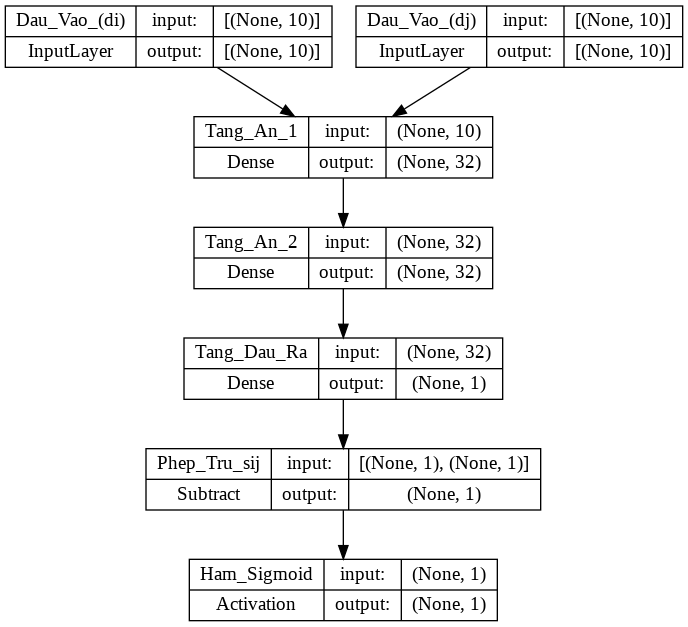

In [4]:
# Để trực quan hóa mô hình RankNet mà chúng ta đã xây dựng bên trên - dùng hàm plot_model()
plot_model(RankNet().build_graph(), show_shapes=True)

**Chúng ta tiến hành tạo một số dữ liệu mẫu/huấn luyện ($\mathcal{D}_{T}$) để thử nghiệm mô hình RankNet vừa xây dựng. Trong đó, mỗi phần tử của tập dữ liệu huấn luyện sẽ bao gồm:**
*   **Một cặp tài liệu ($d_{i}$,$d_{j}$).**
*   **Xác suất nhãn ($P_{ij}$), trong đó: nếu $s_{i} > s_{j}$ thì: $P_{ij}=1$, và $s_{i} = s_{j}$, thì $P_{ij}=0.5$ và còn lại thì $P_{ij}=0$.**

**Để việc thực nghiệm đơn giản - chúng ta sẽ có một tập các tài liệu ở dạng danh sách các vectors biểu diễn tài liệu ($D$). Mỗi vector biểu diễn tài liệu: $\vec{d}$ sẽ có số chiều là [10], hay: $\vec{d}∈\mathbb{R}^{10}$**

**Tập ($D$) là danh sách các tài liệu trả về từ hệ thống cho một truy vấn ($q$)**

**Bên cạnh đó chúng ta cũng sẽ có một danh sách các điểm/trọng số nhãn (ở dạng số thực) thể hiện mức độ liên quan của từng tài liệu/văn bản ($d,d∈D$) với truy vấn ($q$)**


In [8]:
# Tập dữ liệu huấn luyện - chứa các vectors đại diện cho các tài liệu
# Mỗi tài liệu sẽ được biểu diễn bằng một vector số thực có số chiều = 10
D = np.asarray(
  [
    [0.06847967, 0.79326704, 0.63376351, 0.36607879, 0.59269116, 0.01328164,0.88230285, 0.49365282, 0.41221031, 0.34781905],
    [0.46745979, 0.71830635, 0.81618686, 0.88638754, 0.12836164, 0.05918432,0.87038406, 0.47692939, 0.31044275, 0.4862763], 
    [0.46688427, 0.80343473, 0.10020942, 0.50027262, 0.42865049, 0.82228654, 0.04713525, 0.85749257, 0.59647905, 0.09011624], 
    [0.80016535, 0.99472888, 0.0168156, 0.65682011, 0.7793693, 0.21531767, 0.44977229, 0.04755203, 0.32228823, 0.91637983],
    [0.20424918, 0.2397362, 0.14267631, 0.67831066, 0.59543066, 0.75877083, 0.38607362, 0.73232336, 0.96865544, 0.18582693],
    [0.33869757, 0.4152675, 0.26495498, 0.63982803, 0.11849625, 0.11359704, 0.10718447, 0.14275291, 0.20396921, 0.21615031],
    [0.98561439, 0.63274636, 0.58759248, 0.33139431, 0.99517983, 0.3694296, 0.50253355, 0.12783936, 0.10101203, 0.53560751], 
    [0.95859498, 0.07571671, 0.39712067, 0.89934564, 0.0857504, 0.88627685, 0.41978264, 0.05322909, 0.18379332, 0.01388745],
    [0.93053821, 0.361954, 0.79377691, 0.08270594, 0.5046172, 0.62457027, 0.9630082, 0.9913244, 0.90030323, 0.10427289],
    [0.03253636, 0.39942586, 0.73118243, 0.35242242, 0.3190961, 0.89545162, 0.0234359, 0.26831911, 0.16515854, 0.36375583]
  ]
)

# Danh sách các mã định danh của tài liệu, bắt đầu từ [0], ví dụ: [0, 1, 2, v.v.]
D_idxes = [idx for idx in range(0, len(D))]

# Danh sách điểm/trọng số mức độ liên quan của các tài liệu trong tập (D) với truy vấn (q) ở dạng số thực thuộc khoảng [0, 1]
# Trọng số càng cao -> tài liệu càng liên quan với truy vấn (q)
D_rel_scores = np.asarray([0.5, 0.25, 0.38, 0.12, 0.72, 0.44, 0.36, 0.57, 0.78, 0.92, 0.25, 0.56])

**Tiến hành sinh ra tập dữ liệu huấn luyện từ tập dữ liệu ($D$) bên trên, bằng cách tiếp hành bắt cặp các tài liệu trong tập ($D$), thành các cặp ($di$, $dj$) - cùng với nhãn ($Pij$) tương ứng**

**Gọi ($n$) là số lượng tài liệu có trong tập ($D$), vậy ta sẽ có tổng cộng: $\frac{n*(n-1)}{2}$ cặp. Vậy với $n=10$, ta sẽ có [45] cặp**

In [9]:
# Chúng ta khởi tạo các mảng để chứa dữ liệu huấn luyện
di_list = []
dj_list = []
Pij_list = []
pair_ids = []

# Chúng ta tiến hành bắt cặp các tài liệu trong danh sách (D)
# Ví dụ: D = [1, 2, 3] -> [(1, 2), (1, 3), (2, 1), ...]
di_dj_pairs = combinations(D_idxes,2)

for pair_idx, (di_idx, dj_idx) in enumerate(di_dj_pairs):
    # Bỏ vào danh sách vector đại diện cho tài liệu (di) và (dj) tương ứng
    di_list.append(D[di_idx])
    dj_list.append(D[dj_idx])
    # Kiểm tra mức độ liên quan của (di) và (dj) với truy vấn để xác định giá trị (Pij)
    if D_rel_scores[di_idx] == D_rel_scores[dj_idx]:
        Pij = 0.5
    elif D_rel_scores[di_idx] > D_rel_scores[dj_idx]:
        Pij = 1
    else: 
        Pij = 0
    Pij_list.append(Pij)
    pair_ids.append(pair_idx)

# Tiến hành chuyển đổi các tập dữ liệu đã được tạo trên về dạng numpy.array
# Nhằm thuận tiện hơn cho các bước xử lý và tính toán sau này        
di_list = np.array(di_list)
dj_list = np.array(dj_list)
Pij_list = np.array(Pij_list)
pair_ids = np.array(pair_ids)

**Tiến hành chia tập dữ liệu ($D$) ra làm hai phần, bao gồm:**

*   **Huấn luyện (training): dùng cho quá trình huấn luyện/cập nhật/tối ưu các tham số của mô hình xuyên suốt quá trình suy diễn tiến/lan truyền ngược**
*   **Kiểm thử (testing/validation): kiểm tra độ chính xác của mô hình tại các thời điểm huấn luyện/epoch khác nhau - độc lập với tập huấn luyện**

**Trong thực hành này chúng ta sẽ chia tập ($D$) - với tập huấn luyện (training) chiếm 80% và tập kiểm thử (testing/validation) 20%**


In [10]:
# Dùng 20% của tập dữ liệu (D) để làm dữ liệu kiểm thử (testing)
test_size = 0.2

# Chúng ta tiến hành dùng thư viện Scikit-Learn - train_test_split() để tiến hành chia tập dữ liệu làm 2 phần
# Tập dữ huấn luyện (80%) và kiểm thử (20%)
di_list_train, di_list_test, dj_list_train, dj_list_test, Pij_list_train, Pij_list_test, pair_ids_train, pair_ids_test = train_test_split(
    di_list, dj_list, Pij_list, pair_ids, test_size=0.2)

**Tiến hành huấn luyện mô hình RankNet với tập dữ liệu đã được chuẩn bị bên trên, chúng ta sẽ huấn luyện mô hình với các tham số như sau:**

*   **Tốc độ học (learning rate)($\eta$)**
*   **Hàm mất mát (loss function) là hàm: Binary Cross-Entropy (BCE)**
*   **Cơ chế tối ưu hóa mô hình - Stochastic Gradient Descent (SGD)**
*   **Số lượng vòng lặp/epochs huấn luyện**
*   **Kích thước batch_size cho mỗi lượt huấn luyện**


In [11]:
# Khởi tạo các tham số cho quá trình huấn luyện mô hình
learning_rate = 0.01
loss_func = 'binary_crossentropy'
batch_size = 1
number_of_epochs = 50

# Tiến hành khởi tạo mô hình RankNet đã được xây dựng bên trên
ranknet = RankNet()

# Tiến hành khai báo cơ chế tối ưu hóa/huấn luyện mô hình RankNet
# Trong thực hành này chúng ta sẽ sử dụng cơ chế tối ưu bằng Stochastic Gradient Descent (SGD)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# Tiến hành đóng gói mô hình RankNet được khởi tạo với cơ chế tối ưu
# Hàm mất mát được sử dụng sẽ là hàm Binary Cross-Entropy (BCE)
ranknet.compile(optimizer=optimizer, loss=loss_func)

# Tiến hành huấn luyện mô hình RankNet với các cấu hình bên trên & tập dữ liệu huấn luyện
print('Bắt đầu huấn luyện mô hình [RankNet]...')
history = ranknet.fit([di_list_train, dj_list_train], # Đầu vào của mô hình sẽ là vectors (di) và (dj)
                      Pij_list_train, # Nhãn của quá trình học sẽ là xác suất Pij đã được tính
                      epochs=number_of_epochs, 
                      batch_size=batch_size, 
                      # Tương tự như quá trình huấn luyện - quá trình kiểm thử sẽ sử dụng 20% dữ liệu của tập (D)
                      validation_data=([di_list_test, dj_list_test], Pij_list_test))
print('Hoàn tất !')

Bắt đầu huấn luyện mô hình [RankNet]...
Epoch 1/50
36/36 [==============================] - 3s 7ms/step - loss: 0.7230 - val_loss: 0.6741
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6707 - val_loss: 0.6130
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6315 - val_loss: 0.5612
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 0.5967 - val_loss: 0.5125
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 0.5635 - val_loss: 0.4667
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 0.5319 - val_loss: 0.4225
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.5020 - val_loss: 0.3807
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.4742 - val_loss: 0.3434
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 0.4491 - val_loss: 0.3111
Epoch 10/50
36/36 [==============================] - 0s 3ms/step - loss: 0.426

**Tiến hành vẽ biểu đồ thể hiện sự tương quan giữa hiệu suất/độ chính xác của mô hình với tập dữ liệu huấn luyện (training) và kiểm thử (validation)**

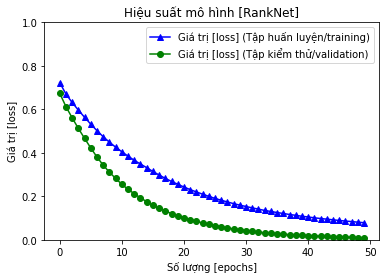

In [12]:
# Viết hàm vẽ biểu đồ sự tương quan giữa hiệu suất mô hình trên 2 tập dữ liệu huấn luyện & kiểm thử
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric, color='blue', label=f'{metric_name} (Tập huấn luyện/training)',marker='^')
    if val_metric is not None: plt.plot(val_metric,color='green', label=f'{metric_name} (Tập kiểm thử/validation)',marker='o')
    plt.xlabel('Số lượng [epochs]')
    plt.ylabel(metric_name)
    plt.legend(loc="upper right")

# Vẽ biểu đồ dựa trên dữ liệu của quá trình huấn luyện [history]
plot_metrics(history.history['loss'], history.history['val_loss'], "Giá trị [loss]", "Hiệu suất mô hình [RankNet]", ylim=1.0)

**Tiến hành kiểm thử mô hình [RankNet] đã được huấn luyện, chúng ta sẽ kiểm tra đơn giản bằng cách - đầu vào chúng ta sẽ cho 2 tài liệu ($d_{i}$) và ($d_{j}$) (ở dạng 2 vectors)**

**Sau đó chúng ta sẽ dùng mô hình [RankNet] để dự đoán thử xác suất tài liệu ($d_{i}$) liên quan với truy vấn ($q$) nhiều hơn ($d_{j}$)**

In [13]:
# Tài liệu (di) - có điểm liên quan đến truy vấn (q) là: 0.5
di = np.asarray([[0.06847967, 0.79326704, 0.63376351, 0.36607879, 0.59269116, 0.01328164,0.88230285, 0.49365282, 0.41221031, 0.34781905]])

# Tài liệu (di) - có điểm liên quan đến truy vấn (q) là: 0.25
dj = np.asarray([[0.46745979, 0.71830635, 0.81618686, 0.88638754, 0.12836164, 0.05918432,0.87038406, 0.47692939, 0.31044275, 0.4862763]])

# Vậy chúng ta có thể thấy rõ ràng rằng tài liệu (di) liên quan đến truy vấn (q) nhiều hơn (dj) (0.5 > 0.25)
# Chúng ta dùng thử mô hình RankNet đã được huấn luyện để kiểm tra thử
predicted_Pij = ranknet.predict([di, dj])
print(f'Xác xuất (Pij) để tài liệu (di) liên quan đến truy vấn (q) hơn (dj) là: [{predicted_Pij[0][0] * 100:.3f}%]')

1/1 [==============================] - 0s 81ms/step
Xác xuất (Pij) để tài liệu (di) liên quan đến truy vấn (q) hơn (dj) là: [98.251%]
